<a href="https://colab.research.google.com/github/thaisflopes/modelo-de-previsao-de-entrega-de-refeicoes/blob/main/modelo_de_previsao_de_entrega_de_refeicoes_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Informações Iniciais
    
Descrição: Trata-se de um projeto para criação de um modelo que consiga prever a demanda futura de uma empresa de entrega de refeições que possui vários centros de atendimento em cidades diferentes, em que foram comparados dois modelos utilizando um algoritmo de Rede Neural Artificial, sendo que o modelo 1 utilizou o otimizador Adam e o modelo 2, o otimizador rmsprop.

Projeto desenvolvido na disciplina Fundamentos de Deep Learning.

Elaborado em 20/03/2021 por Thaís Lopes (https://github.com/thaisflopes)


## 1 - Descrição do Problema

Em qualquer negócio é importante ter um bom planejamento a fim de evitar que o funcionamento da empresa seja afetado. No caso das empresas do segmento de alimentação, esse planejamento está ligado à capacidade produtiva necessária para atender a demanda e ao levantamento das quantidades certas de insumos e alimentos para o preparo das refeições. Em relação aos alimentos, deve-se considerar também que eles são perecíveis, assim, a fim de evitar desperdícios, muitas vezes é necessário que a compra seja realizada semanalmente ou até mesmo diariamente. Nesse sentido, a previsão da demanda auxilia os gestores nesse planejamento, pois por meio dela eles tem uma noção da quantidade de matéria-prima e de pessoal que eles precisarão para fornecer seu serviço com qualidade. 

Com base nisso, esse projeto analisará os dados de uma empresa de entrega de refeições que possui vários centros de atendimento em cidades diferentes. O problema consiste em achar um modelo que consiga prever a demanda da empresa, para ajudá-la a planejar seu estoque de matéria-prima.

# 2- Algoritmo

Esse problema foi analisado no projeto final para a disciplina de Introdução à Aprendizagem de Máquina, em que foram utilizados:
- a regressão linear (LinearRegression), por ser um algoritmo muito utilizado para realizar previsões com base em série histórica; e
- alguns algoritmos que usam a lógica de árvore de decisão (DecisionTreeRegressor, RandomForestRegressor e XGBRegressor), pois costumam apresentar melhores resultados quando há dados binários no conjunto de dados.

No projeto atual, dando continuidade a esse estudo será utilizado um algoritmo de Rede Neural Artificial. Esse tipo de rede neural foi escolhida porque ao contrário de muitas outras técnicas de previsão, a RNA não impõe nenhuma restrição às variáveis​ de entrada. Além disso, muitos estudos mostraram que esses sistemas podem modelar melhor dados com variação não constante pela sua capacidade de aprender relações ocultas que não respeitam funções matemáticas. Essa funcionalidade é útil na previsão de séries temporais financeiras, por exemplo, em que a volatilidade dos dados é muito alta.

# 3 - Dataset

In [ ]:
#Importando bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Carregando as bases de dados
info_centros = pd.read_csv("fulfilment_center_info.csv")
info_refeicoes = pd.read_csv("meal_info.csv")
dados_treino = pd.read_csv("train.csv")
dados_teste = pd.read_csv("test.csv")

In [ ]:
info_centros.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [ ]:
info_refeicoes.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [ ]:
dados_treino.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [ ]:
dados_teste.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


#### Significado de cada variável:

##### Base info_centros:

center_id: ID único para cada centro de distribuição

city_code: ID único para cada cidade

region_code: ID único para cada região

center_type: tipo de centro anônimo

op_area: área de operação (em km^2)

##### Base info_refeicoes:

meal_id: ID único para cada refeição

category: tipo de refeição

cuisine: cozinha da refeição

##### Bases dados_treino e dados_teste:

id: ID único

week: número da semana

center_id: ID único para cada centro de distribuição

meal_id: ID único para cada refeição

checkout_price: preço final incluindo desconto, impostos e taxa de entrega

base_price: preço base da refeição

emailer_for_promotion: email enviado para promoção da refeição

homepage_featured: refeição apresentada na página inicial

num_orders: contagem de pedidos (alvo)

# 4 - Tratamento dos dados

### 4.1 Mesclando bases
As bases info_centros e dados_treino possuem a coluna "center_id" em comum. E as bases info_refeicoes e dados_treino possuem a coluna "meal_id" em comum. Assim, a seguir essas bases seram mescladas utilizando o pandas.DataFrame.merge para facilitar a manipulação e a análise dos dados.

In [ ]:
dados1 = pd.merge(dados_treino, info_centros, how='inner', on='center_id')
dados1.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0


In [ ]:
dados2 = pd.merge(dados1, info_refeicoes, how='inner', on='meal_id')
dados2.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1018704,2,55,1885,135.83,152.29,0,0,323,647,56,TYPE_C,2.0,Beverages,Thai
2,1196273,3,55,1885,132.92,133.92,0,0,96,647,56,TYPE_C,2.0,Beverages,Thai
3,1116527,4,55,1885,135.86,134.86,0,0,163,647,56,TYPE_C,2.0,Beverages,Thai
4,1343872,5,55,1885,146.50,147.50,0,0,215,647,56,TYPE_C,2.0,Beverages,Thai


### 4.2 Removendo linhas duplicadas

In [ ]:
dados2.shape

(456548, 15)

In [ ]:
linhas_duplicadas_dados2 = dados2[dados2.duplicated()]
print("Número de linhas duplicadas: ", linhas_duplicadas_dados2.shape)

Número de linhas duplicadas:  (0, 15)


In [ ]:
dados_teste.shape

(32573, 8)

In [ ]:
linhas_duplicadas_dados_teste = dados_teste[dados_teste.duplicated()]
print("Número de linhas duplicadas: ", linhas_duplicadas_dados_teste.shape)

Número de linhas duplicadas:  (0, 8)


Os datasets não possuem linhas duplicadas.

### 4.3 Eliminando os valores ausentes ou nulos

In [ ]:
print(dados2.isnull().sum())

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
city_code                0
region_code              0
center_type              0
op_area                  0
category                 0
cuisine                  0
dtype: int64


In [ ]:
print(dados_teste.isnull().sum())

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
dtype: int64


Os datasets também não possuem dados ausentes.

### 4.4 Visualizando os dados

In [ ]:
for i in dados2.columns:
    print(i)
    print('Unique Values: '+str(len(dados2.groupby([i]).count())))
    print(dados2[i].value_counts())

id
Unique Values: 456548
1050623    1
1166483    1
1141895    1
1119368    1
1121417    1
          ..
1389043    1
1378804    1
1376757    1
1382902    1
1048576    1
Name: id, Length: 456548, dtype: int64
week
Unique Values: 145
122    3359
105    3348
106    3347
140    3332
123    3331
       ... 
13     2838
12     2831
14     2830
7      2795
8      2786
Name: week, Length: 145, dtype: int64
center_id
Unique Values: 77
13     7046
10     7015
52     6993
43     6970
67     6915
       ... 
139    4627
57     4501
162    4366
41     4083
91     3432
Name: center_id, Length: 77, dtype: int64
meal_id
Unique Values: 51
2290    11138
1062    11137
1727    11136
1109    11134
1754    11132
2707    11123
1778    11121
1993    11116
1962    11114
1971    11102
1885    11092
2581    11072
2826    11057
2322    11002
1558    10952
1207    10806
2640    10747
1230    10746
1878    10527
2631    10458
2539    10451
1543    10236
2760    10209
1248     9939
2664     9853
2704     9811
1445   

Observa-se que:
- Os dados são registros de 145 semanas;
- Existem 77 ids de centros de distribuição;
- Existem 51 ids de refeições;
- Os centros estão em 51 cidades e 8 regiões;
- Existem 3 tipos de centros (A, B e C);
- Existem 30 tipos de área de operação;
- Existem 14 tipos de refeição; e
- As refeições são de 4 tipos de cozinhas.

In [ ]:
#Calculando a quantidade total de pedidos por semana
pedidos_por_semana = dados2.groupby(['week'])['num_orders'].sum()
pedidos_por_semana = pd.DataFrame(pedidos_por_semana)
pedidos_por_semana

,num_orders
week,
1,792261
2,787084
3,695262
4,743529
5,1198675
...,...
141,776240
142,739661
143,759926


In [ ]:
#Gráfico da quantidade total de pedidos por semana
import plotly.graph_objs as go
import plotly.offline as pyoff
plot_data = [
    go.Scatter(
        x=pedidos_por_semana.index,
        y=pedidos_por_semana['num_orders'],
        name='série de num_orders',
        marker = dict(color = 'Blue'),
    )
]
plot_layout = go.Layout(
        title='Total de pedidos por semana',
        yaxis_title='Total de pedidos',
        xaxis_title='Semana',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
#Calculando a quantidade de pedidos por centro
pedidos_por_centro = dados2.groupby(['center_type'])['num_orders'].sum()
pedidos_por_centro = pd.DataFrame(pedidos_por_centro)
pedidos_por_centro

,num_orders
center_type,
TYPE_A,68978517
TYPE_B,29996073
TYPE_C,20582895


Observa-se que o centro tipo A possui a demanda bem maior que os outros. Os centros tipo B e tipo C possuem a demanda próxima, sendo a do tipo B um pouco maior.

In [ ]:
#Calculando a quantidade de pedidos por categoria
pedidos_por_categoria = dados2.groupby(['category'])['num_orders'].sum()
pedidos_por_categoria = pd.DataFrame(pedidos_por_categoria)
pedidos_por_categoria.sort_values(by=['num_orders'])

,num_orders
category,
Biryani,631848
Fish,871959
Soup,1039646
Pasta,1637744
Desert,1940754
Seafood,2715714
Extras,3984979
Starters,4649122
Other Snacks,4766293


Observa-se que as refeições com maior demanda são a Beverages (bebidas), o Rice Bowl (tigela de arroz) e o Sandwish (sanduíche).

In [ ]:
#Calculando a quantidade de pedidos por cozinha
pedidos_por_cozinha = dados2.groupby(['cuisine'])['num_orders'].sum()
pedidos_por_cozinha = pd.DataFrame(pedidos_por_cozinha)
pedidos_por_cozinha.sort_values(by=['num_orders'])

,num_orders
cuisine,
Continental,16914439
Indian,25792544
Thai,32677670
Italian,44172832


Observa-se que a cozinha com maior demanda é a italiana, seguida pela tailandesa, indiana e continental.

In [ ]:
cat_var = ['center_type','category','cuisine']

In [ ]:
#Gráficos da quantidade de pedidos por semana divididos por tipo de centro, tipo de refeição e tipo de cozinha
for i in cat_var:
    grp=dados2.groupby([i])
    grp=pd.DataFrame(grp)
    lis=grp[0]
    x=0
    plot_data=[]
    for j in lis:
        print(i)
        print(j)
        data = dados2[dados2[i]==j]
        data = pd.DataFrame(data)
        tot_orders = data.groupby(['week'])['num_orders'].sum()
        tot_orders = pd.DataFrame(tot_orders)
       
        plot_data.append(go.Scatter(
                x=tot_orders.index,
                y=tot_orders['num_orders'],
                name=str(j),
            ))
        
        x+=1
    plot_layout = go.Layout(
            title='Total de pedidos por semana por '+str(i),
            yaxis_title='Total de pedidos',
            xaxis_title='Semana',
            plot_bgcolor='rgba(0,0,0,0)'
        )
    fig = go.Figure(data=plot_data, layout=plot_layout)
    pyoff.iplot(fig)

center_type
TYPE_A
center_type
TYPE_B
center_type
TYPE_C


category
Beverages
category
Biryani
category
Desert
category
Extras
category
Fish
category
Other Snacks
category
Pasta
category
Pizza
category
Rice Bowl
category
Salad
category
Sandwich
category
Seafood
category
Soup
category
Starters


cuisine
Continental
cuisine
Indian
cuisine
Italian
cuisine
Thai


### 4.5 Preparando os dados para os modelos

Foram disponibilizados dois datasets dados_treino e dados_teste, porém os dados_teste não possuem a coluna num_orders, pois referem-se aos registros das semanas 146-155, que se deseja prever a demanda. Assim, para treinar os algoritmos será utilizado apenas o dataset dados_treino.

Nos itens 4.2 e 4.3 constatou-se que o dataset não possui linhas faltando e nem valores ausentes. Sendo assim, a seguir será analisado a correlação das variáveis desse dataset e seus dados serão divididos em dados de treino e teste.



#### 4.5.1 Analisando a correlação entre as variáveis

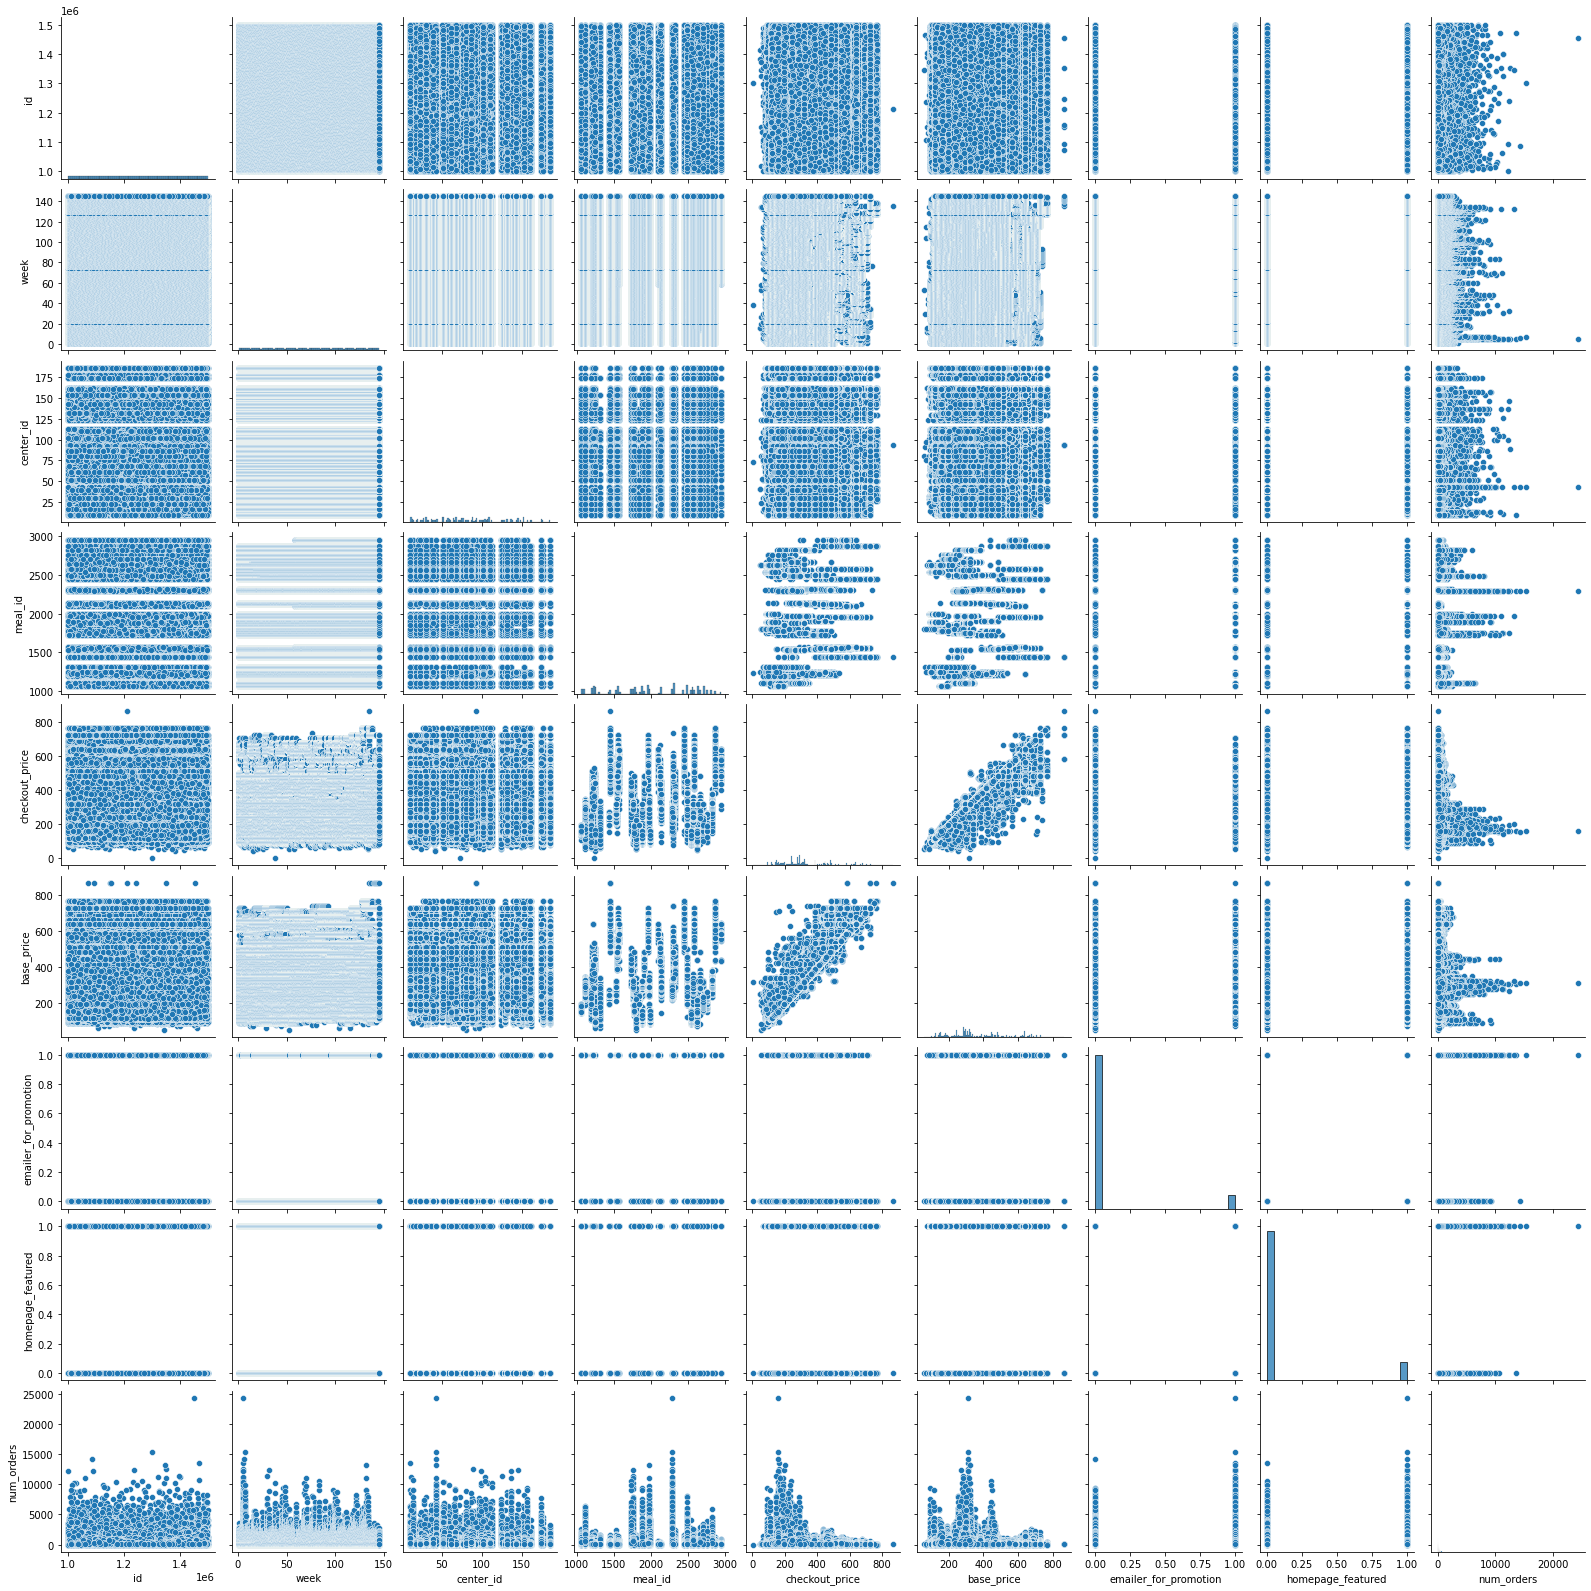

In [ ]:
#Explorando os tipos de relações em todo o conjunto de dados
sns.pairplot(dados_treino)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
id,1.000000,0.002225,0.002641,0.000488,0.001941,0.002909,0.002001,0.003111,0.000702
week,0.002225,1.000000,-0.003450,0.019814,0.026581,0.028614,-0.000841,-0.008263,-0.017210
center_id,0.002641,-0.003450,1.000000,0.009893,0.001348,0.000604,0.013658,-0.005043,-0.053035
meal_id,0.000488,0.019814,0.009893,1.000000,0.010748,0.002605,0.013402,0.016354,0.010597
checkout_price,0.001941,0.026581,0.001348,0.010748,1.000000,0.953389,0.004818,-0.057184,-0.282108
base_price,0.002909,0.028614,0.000604,0.002605,0.953389,1.000000,0.171173,0.057156,-0.222306
emailer_for_promotion,0.002001,-0.000841,0.013658,0.013402,0.004818,0.171173,1.000000,0.390534,0.277147
homepage_featured,0.003111,-0.008263,-0.005043,0.016354,-0.057184,0.057156,0.390534,1.000000,0.294490
num_orders,0.000702,-0.017210,-0.053035,0.010597,-0.282108,-0.222306,0.277147,0.294490,1.000000


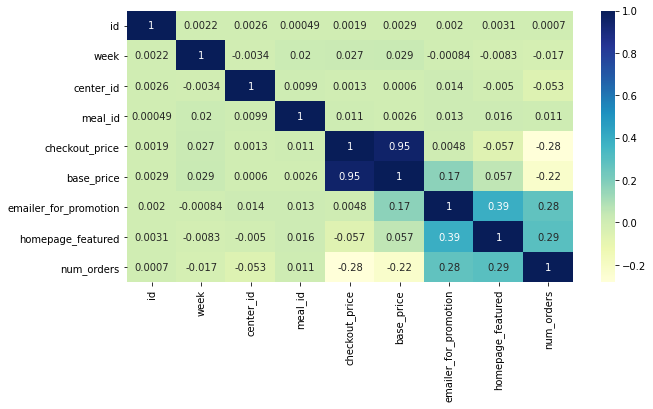

In [ ]:
#Calculando a correlação entre as variáveis
plt.figure(figsize=(10,5))
c= dados_treino.corr()
sns.heatmap(c,cmap="YlGnBu",annot=True)
c

Observa-se que as variáveis com maior correlação são base_price e checkout_price (0.95), isso faz sentido visto que o preço final é o preço base com desconto, impostos e taxa de entrega.

Outras correlações significativas são:
* emailer_for_promotion e homepage_featured: 0.39;
* num_order e homepage_featured: 0.29;
* num_order e emailer_for_promotion 0.28; e
* emailer_for_promotion e base_price: 0.17.

#### 4.5.2 Dividindo dados de treino e teste

In [ ]:
dados_treino.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [ ]:
#Retirando a coluna id, pois não ajudará na previsão
dados_treino = dados_treino.drop(labels=['id'], axis = 1)
dados_treino.head()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1,55,1885,136.83,152.29,0,0,177
1,1,55,1993,136.83,135.83,0,0,270
2,1,55,2539,134.86,135.86,0,0,189
3,1,55,2139,339.50,437.53,0,0,54
4,1,55,2631,243.50,242.50,0,0,40


In [ ]:
X = dados_treino.drop(['num_orders'], axis=1).values
y = dados_treino['num_orders'].values

In [ ]:
X.shape

(456548, 7)

In [ ]:
y.shape

(456548,)

In [ ]:
y = y.reshape (-1,1)
y.shape

(456548, 1)

In [ ]:
#Normalizando os valores para deixá-los na escala de 0 a 1
#Deixando na mesma escala a rede neural não vai considerar um atributo mais importante que outro, além de ajudar no processamento para processar mais rápido
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

In [ ]:
#Dividindo os dados em treino e teste
from sklearn.model_selection import train_test_split 
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=0)

#5 - Treinamento

##MODELO 1 - Utilizando o otimizador Adam

In [ ]:
#Importando biblioteca
import tensorflow as tf
tf.__version__

'2.4.1'

In [ ]:
#Criando o modelo
modelo1 = tf.keras.models.Sequential()

#Camada de entrada com 7 neurônios e primeira camada oculta com 100 neurônios
modelo1.add(tf.keras.layers.Dense(input_shape=(7,), units = 100, activation='relu'))

#Segunda camada oculta com 100 neurônios
modelo1.add(tf.keras.layers.Dense(units=100, activation='relu'))

#Terceira camada oculta com 100 neurônios
modelo1.add(tf.keras.layers.Dense(units=100, activation='relu'))

#Quarta camada oculta com 100 neurônios
modelo1.add(tf.keras.layers.Dense(units=100, activation='relu'))

#Camada de saída com 1 neurônio
modelo1.add(tf.keras.layers.Dense(units=1, activation='linear'))

In [ ]:
modelo1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               800       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 31,201
Trainable params: 31,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Definindo otimizador
modelo1.compile(optimizer='Adam', loss='mean_squared_error')

In [ ]:
#Treinamento
historico_epocas1 = modelo1.fit(X_treino, y_treino, epochs = 200, batch_size = 100, validation_split=0.2)

Epoch 1/200
2922/2922 [==============================] - 9s 2ms/step - loss: 2.2147e-04 - val_loss: 1.7949e-04
Epoch 2/200
2922/2922 [==============================] - 6s 2ms/step - loss: 1.6367e-04 - val_loss: 1.5483e-04
Epoch 3/200
2922/2922 [==============================] - 6s 2ms/step - loss: 1.4543e-04 - val_loss: 1.5775e-04
Epoch 4/200
2922/2922 [==============================] - 6s 2ms/step - loss: 1.4278e-04 - val_loss: 1.4007e-04
Epoch 5/200
2922/2922 [==============================] - 6s 2ms/step - loss: 1.4085e-04 - val_loss: 1.4045e-04
Epoch 6/200
2922/2922 [==============================] - 6s 2ms/step - loss: 1.3228e-04 - val_loss: 1.4529e-04
Epoch 7/200
2922/2922 [==============================] - 6s 2ms/step - loss: 1.3626e-04 - val_loss: 1.4860e-04
Epoch 8/200
2922/2922 [==============================] - 6s 2ms/step - loss: 1.2939e-04 - val_loss: 1.3264e-04
Epoch 9/200
2922/2922 [==============================] - 6s 2ms/step - loss: 1.2547e-04 - val_loss: 1.2876e-04
E

In [ ]:
historico_epocas1.history.keys()

dict_keys(['loss', 'val_loss'])

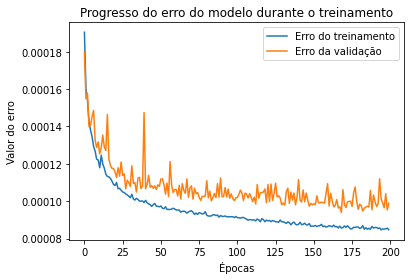

In [ ]:
#Gráfico para visualizar o número de erros no treinamento e na validação
plt.plot(historico_epocas1.history['loss'])
plt.plot(historico_epocas1.history['val_loss'])
plt.title('Progresso do erro do modelo durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Valor do erro')
plt.legend(['Erro do treinamento', 'Erro da validação'])

##MODELO 2 - Utilizando o otimizador rmsprop

In [ ]:
#Criando o modelo
modelo2 = tf.keras.models.Sequential()

#Camada de entrada com 7 neurônios e primeira camada oculta com 100 neurônios
modelo2.add(tf.keras.layers.Dense(input_shape=(7,), units = 100, activation='relu'))

#Segunda camada oculta com 100 neurônios
modelo2.add(tf.keras.layers.Dense(units=100, activation='relu'))

#Terceira camada oculta com 100 neurônios
modelo2.add(tf.keras.layers.Dense(units=100, activation='relu'))

#Quarta camada oculta com 100 neurônios
modelo2.add(tf.keras.layers.Dense(units=100, activation='relu'))

#Camada de saída com 1 neurônio
modelo2.add(tf.keras.layers.Dense(units=1, activation='linear'))

In [ ]:
modelo2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               800       
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 31,201
Trainable params: 31,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Definindo otimizador
modelo2.compile(optimizer='rmsprop', loss='mean_squared_error')

In [ ]:
#Treinamento
historico_epocas2 = modelo2.fit(X_treino, y_treino, epochs = 200, batch_size = 100, validation_split=0.2)

Epoch 1/200
2922/2922 [==============================] - 8s 2ms/step - loss: 2.4219e-04 - val_loss: 1.7777e-04
Epoch 2/200
2922/2922 [==============================] - 7s 2ms/step - loss: 1.5648e-04 - val_loss: 1.7794e-04
Epoch 3/200
2922/2922 [==============================] - 7s 2ms/step - loss: 1.4713e-04 - val_loss: 1.4928e-04
Epoch 4/200
2922/2922 [==============================] - 7s 2ms/step - loss: 1.4142e-04 - val_loss: 1.4079e-04
Epoch 5/200
2922/2922 [==============================] - 7s 2ms/step - loss: 1.3730e-04 - val_loss: 1.5134e-04
Epoch 6/200
2922/2922 [==============================] - 7s 2ms/step - loss: 1.3280e-04 - val_loss: 1.5015e-04
Epoch 7/200
2922/2922 [==============================] - 7s 2ms/step - loss: 1.3297e-04 - val_loss: 1.3455e-04
Epoch 8/200
2922/2922 [==============================] - 7s 2ms/step - loss: 1.2576e-04 - val_loss: 1.3484e-04
Epoch 9/200
2922/2922 [==============================] - 7s 2ms/step - loss: 1.2842e-04 - val_loss: 1.3888e-04
E

In [ ]:
historico_epocas2.history.keys()

dict_keys(['loss', 'val_loss'])

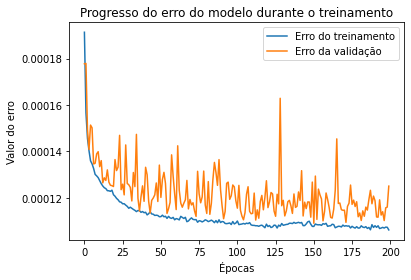

In [ ]:
#Gráfico para visualizar o número de erros no treinamento e na validação
plt.plot(historico_epocas2.history['loss'])
plt.plot(historico_epocas2.history['val_loss'])
plt.title('Progresso do erro do modelo durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Valor do erro')
plt.legend(['Erro do treinamento', 'Erro da validação'])

### 5.1 Guarde o modelo

In [ ]:
#Instalando biblioteca
!pip install h5py
from keras.models import model_from_json

In [ ]:
#Salvando o modelo1 no json
modelo1_json = modelo1.to_json()
with open("modelo1.json", "w") as json_file:
    json_file.write(modelo1_json)
#Serializando pesos para HDF5
modelo1.save_weights("modelo1.h5")
print("Salvando modelo no disco")

Salvando modelo no disco


In [ ]:
#Salvando o modelo2 no json
modelo2_json = modelo2.to_json()
with open("modelo2.json", "w") as json_file:
    json_file.write(modelo2_json)
#Serializando pesos para HDF5
modelo2.save_weights("modelo2.h5")
print("Salvando modelo no disco")

Salvando modelo no disco


### 5.2 Recupere o modelo

In [ ]:
#Carregando json e recuperando o modelo1
arquivo1_json = open('modelo1.json')
modelo1_json_carregado = arquivo1_json.read()
arquivo1_json.close()
modelo1_recup = model_from_json(modelo1_json_carregado)
#Carregando pesos no modelo recuperado
modelo1_recup.load_weights("modelo1.h5")

In [ ]:
#Carregando json e recuperando o modelo2
arquivo2_json = open('modelo2.json')
modelo2_json_carregado = arquivo2_json.read()
arquivo2_json.close()
modelo2_recup = model_from_json(modelo2_json_carregado)
#Carregando pesos no modelo recuperado
modelo2_recup.load_weights("modelo2.h5")

# 6 - Previsão

## MODELO 1

In [ ]:
#Previsão
y_predicao1 = modelo1.predict(X_teste)

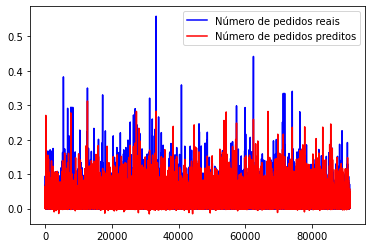

In [ ]:
#Gráfico para visualizar o número de pedidos real e os obtidos com o modelo
plt.plot(y_teste, color='blue', label="Número de pedidos reais")
plt.plot(y_predicao1, color='red', label="Número de pedidos preditos")
plt.legend()
plt.show()

In [ ]:
#Desnormalizando os dados
y_predicao_original1 = scaler.inverse_transform(y_predicao1)
y_predicao_original1

array([[ 109.14844],
       [ 191.64333],
       [ 139.12077],
       ...,
       [ 341.585  ],
       [1416.1157 ],
       [ 265.4088 ]], dtype=float32)

In [ ]:
#Desnormalizando os dados
y_teste_original = scaler.inverse_transform(y_teste)
y_teste_original

array([[122.],
       [216.],
       [ 95.],
       ...,
       [161.],
       [796.],
       [189.]])

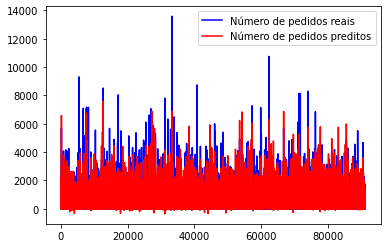

In [ ]:
#Gráfico para visualizar o número de pedidos real e os obtidos com o modelo com os valores originais
plt.plot(y_teste_original, color='blue', label="Número de pedidos reais")
plt.plot(y_predicao_original1, color='red', label="Número de pedidos preditos")
plt.legend()
plt.show()

##MODELO 2

In [ ]:
#Previsão
y_predicao2 = modelo2.predict(X_teste)

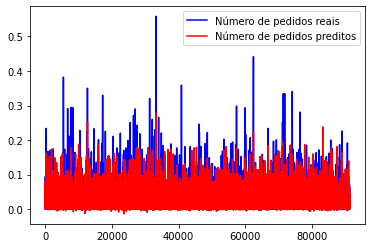

In [ ]:
#Gráfico para visualizar o número de pedidos real e os obtidos com o modelo
plt.plot(y_teste, color='blue', label="Número de pedidos reais")
plt.plot(y_predicao2, color='red', label="Número de pedidos preditos")
plt.legend()
plt.show()

In [ ]:
#Desnormalizando os dados
y_predicao_original2 = scaler.inverse_transform(y_predicao2)
y_predicao_original2

array([[319.83243],
       [176.10184],
       [220.32872],
       ...,
       [573.99554],
       [962.2009 ],
       [343.7043 ]], dtype=float32)

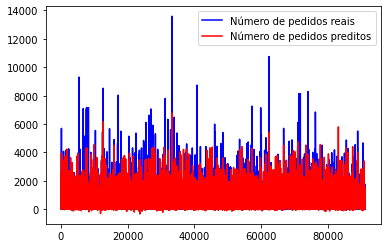

In [ ]:
#Gráfico para visualizar o número de pedidos real e os obtidos com o modelo com os valores originais
plt.plot(y_teste_original, color='blue', label="Número de pedidos reais")
plt.plot(y_predicao_original2, color='red', label="Número de pedidos preditos")
plt.legend()
plt.show()

# 7 - Avaliação dos resultados

Para avaliar o modelo, por ser de regressão, serão utilizadas as seguintes métricas:
* o MAE que representa a diferença entre os valores originais e preditos extraídos pela média da diferença absoluta sobre o conjunto de dados;
* o MSE que representa a diferença entre os valores originais e previstos extraídos ao quadrado da diferença média sobre o conjunto de dados;
* o RMSE que é a taxa de erro pela raiz quadrada de MSE; 

Para essas métricas quanto menor o valor, mais próximo o modelo está de acertar.

##MODELO 1

In [ ]:
#Calculando métricas
from sklearn import metrics
MAE1 = metrics.mean_absolute_error(y_teste_original, y_predicao_original1)
MSE1 = metrics.mean_squared_error(y_teste_original, y_predicao_original1)
RMSE1 = np.sqrt(metrics.mean_squared_error(y_teste_original, y_predicao_original1))
metricas = (MAE1, MSE1, RMSE1)
pd.DataFrame(metricas, index=["MAE", "MSE", "RMSE"], columns=["Rede Neural Artificial - Modelo 1"])

,Rede Neural Artificial - Modelo 1
MAE,120.255998
MSE,51194.762517
RMSE,226.262596


##MODELO 2

In [ ]:
#Calculando métricas
from sklearn import metrics
MAE2 = metrics.mean_absolute_error(y_teste_original, y_predicao_original2)
MSE2 = metrics.mean_squared_error(y_teste_original, y_predicao_original2)
RMSE2 = np.sqrt(metrics.mean_squared_error(y_teste_original, y_predicao_original2))
metricas = (MAE2, MSE2, RMSE2)
pd.DataFrame(metricas, index=["MAE", "MSE", "RMSE"], columns=["Rede Neural Artificial - Modelo 2"])

,Rede Neural Artificial - Modelo 2
MAE,160.080474
MSE,65491.295672
RMSE,255.912672


#8 - Avaliando desempenho dos modelos dos projetos de Introdução à Aprendizagem de Máquina e Fundamentos de Deep Learning

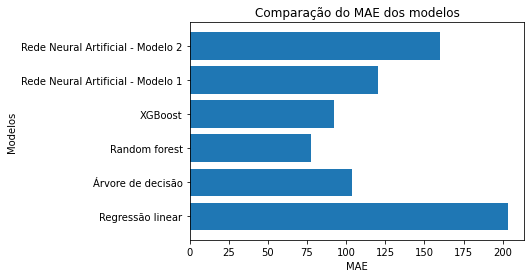

In [ ]:
modelos = ['Regressão linear', 'Árvore de decisão', 'Random forest', 'XGBoost', 'Rede Neural Artificial - Modelo 1', 'Rede Neural Artificial - Modelo 2']
mae = [203.640457, 103.763115, 77.798710, 92.091328, MAE1, MAE2]
plt.barh(modelos, mae)
plt.ylabel("Modelos")
plt.xlabel("MAE")
plt.title("Comparação do MAE dos modelos")
plt.show()

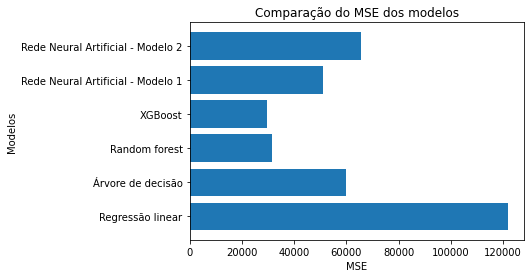

In [ ]:
modelos = ['Regressão linear', 'Árvore de decisão', 'Random forest', 'XGBoost', 'Rede Neural Artificial - Modelo 1', 'Rede Neural Artificial - Modelo 2']
mse = [122000.234079, 59958.817567, 31630.986681, 29481.891624, MSE1, MSE2]
plt.barh(modelos, mse)
plt.ylabel("Modelos")
plt.xlabel("MSE")
plt.title("Comparação do MSE dos modelos")
plt.show()

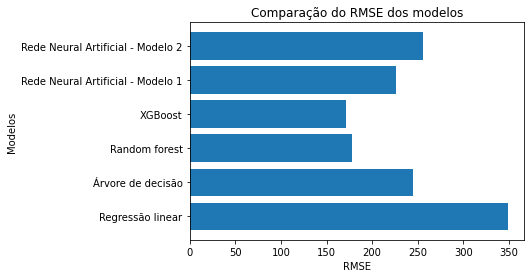

In [ ]:
modelos = ['Regressão linear', 'Árvore de decisão', 'Random forest', 'XGBoost', 'Rede Neural Artificial - Modelo 1', 'Rede Neural Artificial - Modelo 2']
rmse = [349.285319, 244.864897, 177.851024, 171.702917, RMSE1, RMSE2]
plt.barh(modelos, rmse)
plt.ylabel("Modelos")
plt.xlabel("RMSE")
plt.title("Comparação do RMSE dos modelos")
plt.show()

### 8.1 Considerações

No projeto de Introdução à Aprendizagem de Máquina, observou-se que o XGBoost obteve um desempenho melhor na maioria das métricas, porém o Random Forest também apresentou resultados bem próximos, superando o XGBoost no MAE. Assim, esses dois modelos demonstraram ser os melhores para a resolução do problema, mas ainda seria necessário ajustar o modelo a fim de reduzir os erros. 

Por outro lado, entre os modelos de rede neural artificial elaborados nesse projeto de Fundamentos de Deep Learning observa-se que o modelo que utilizou o otimizador Adam teve um desempenho melhor do que o com o otimizador rmrprop. Entretanto, de forma geral, os modelos apresentaram métricas próximas às do modelo de Árvore de Decisão, sendo piores do que os dois modelos desenvolvidos na disciplina anterior. Algumas hipóteses para esse resultado de desempenho são:
- as variavéis utilizadas possuem uma correlação baixa, o que pode dificultar para o modelo encontrar padrões;
- existem diferentes tipos de dados de entrada (variáveis que indicam sim ou não - emailer_for_promotion, homepage_featured, que representam valores - checkout_price, base_price, que representam códigos - center_id,	meal_id e que representam data - week), talvez seja necessário um refinamento dos dados de entrada para que a rede consiga um desempenho melhor.


#9 - Conclusões

Esse projeto tinha como objetivo encontrar um modelo capaz de prever a demanda de uma empresa de entrega de comida, a fim de ajudá-la em seu planejamento.

Durante os treinos dos modelos, foram testados diferentes parâmetros, como:

1. Os modelos utilizaram otimizadores diferentes justamente para observar qual teria melhor desempenho, sendo o Adam o que se destacou;

2. Os modelos foram elaborados, primeiramente, com todas as funções de ativação sendo ReLu, porém nesse cenário o erro de todas as épocas foi o mesmo, o que não gerou uma boa previsão dos dados. Por isso, a função de ativação da camada de saída foi alterada para linear; e

3. Os modelos foram treinados com 100 e 200 épocas, sendo esse último o que apresentou melhores métricas.

Assim, conclui-se que os modelos de rede neural artificial desenvolvidos nesse projeto conseguiram prever a demanda, porém ainda são necessários ajustes nos parâmetros utilizados ou até mesmo modificações na arquitetura utilizando outros tipos de rede neural para obter melhores resultado.

## Referências

Base de dados utilizada: https://www.kaggle.com/ghoshsaptarshi/av-genpact-hack-dec2018

Entendendo o funcionamento de uma Rede Neural Artificial: https://medium.com/brasil-ai/entendendo-o-funcionamento-de-uma-rede-neural-artificial-4463fcf44dd0

Gráficos de barra com matplotlib: https://medium.com/horadecodar/gr%C3%A1ficos-de-barra-com-matplotlib-85628bfc4351

Introdução às Redes Neurais Artificiais: https://matheusfacure.github.io/2017/03/05/ann-intro/

Regression Accuracy Check in Python (MAE, MSE, RMSE, R-Squared): https://www.datatechnotes.com/2019/10/accuracy-check-in-python-mae-mse-rmse-r.html

Um guia simples para entender as redes neurais artificiais: https://transformacaodigital.com/tecnologia/redes-neurais-artificiais/